# Importing Libraries

In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Data Collection

In [2]:
df = pd.read_csv("Bank Customer Churn Prediction.csv")

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data Preprocessing

In [4]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.drop(['customer_id'], axis=1, inplace=True)

Encode categorical variables

In [7]:
df = pd.get_dummies(df, columns=['country', 'gender'], drop_first=True)

Separate features and target

In [8]:
X = df.drop('churn', axis=1)
y = df['churn']

# Feature scaling


In [9]:
scale_cols = ['credit_score', 'age', 'balance', 'estimated_salary']
scaler = StandardScaler()
X[scale_cols] = scaler.fit_transform(X[scale_cols])

Save Scalar

In [10]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Save Feature Names for Prediction Alignment

In [11]:
joblib.dump(X.columns.tolist(), 'model_features.pkl')

['model_features.pkl']

# Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle Class Imbalance with SMOTE

In [13]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Model Training & Hyperparameter Tuning

In [14]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid.fit(X_res, y_res)
best_rf = grid.best_estimator_

Train XGBoost

In [15]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_res, y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Train Logistic Regression

In [16]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_res, y_res)

LogisticRegression(max_iter=1000)

# Ensemble Learning

In [17]:
voting_model =VotingClassifier(estimators=[
    ('rf', best_rf),
    ('xgb', xgb_model),
    ('lr', lr_model)
], voting='soft')

voting_model.fit(X_res, y_res)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=20,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weig...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lr', LogisticRegression(max_iter=1000))],
                 voting='soft')

# Model Evaluation

In [18]:
y_pred = voting_model.predict(X_test)

In [19]:
print("Accuracy", accuracy_score(y_test, y_pred))

Accuracy 0.8375


In [20]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[1422  171]
 [ 154  253]]


In [21]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      1593
           1       0.60      0.62      0.61       407

    accuracy                           0.84      2000
   macro avg       0.75      0.76      0.75      2000
weighted avg       0.84      0.84      0.84      2000



# Feature Importance (Random Forest)

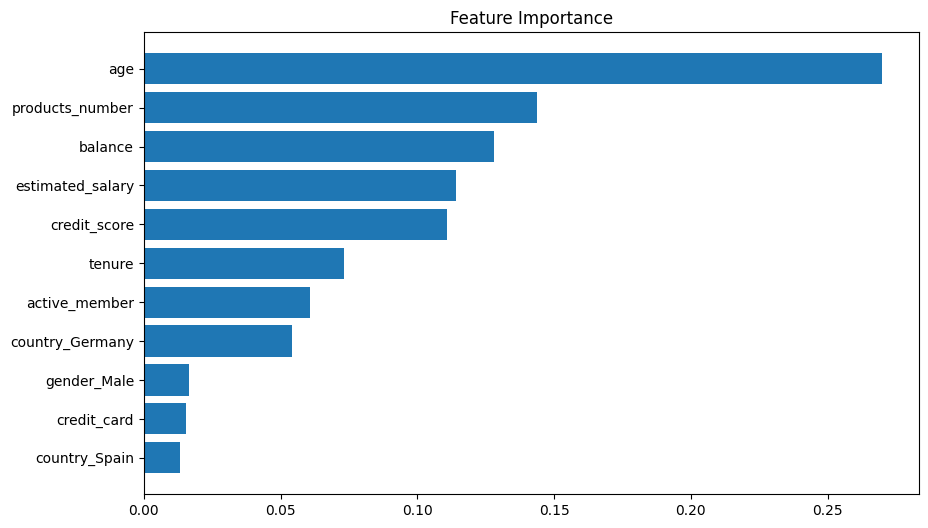

In [22]:
importances = best_rf.feature_importances_
features = X.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [features[i] for i in indices])
plt.gca().invert_yaxis()
plt.show()

# Save Model

In [23]:
joblib.dump(voting_model, 'optimized_churn_model.pkl')

['optimized_churn_model.pkl']